In [6]:
from datetime import datetime
import pandas as pd
import numpy as np
from dateutil.parser import parse
import datetime
from dateutil.parser import parse
import math
from numpy import mean

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline as SKLpipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from dtreeviz.trees import dtreeviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBLpipeline

from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 30)

In [117]:
# read df pickle
df_alg = pd.read_pickle("objects/df_alg-HAB_preprocessing_5_1")
df_cons = pd.read_pickle("objects/df_cons4-HAB_preprocessing_5_1")
#TEST df_cons = pd.read_pickle("objects/df_cons-HAB_modelling_4_2_1_A=no_chem&noASP")

df_cons.set_index('date', inplace=True)
# slice by station and time
#df_cons = df_cons[df_cons["sampling station"] == "Strunjan"].loc["2008-01-01" : "2021-12-31"]
# df_cons = df_cons.loc["1994-01-01" : "2019-12-31"]

df_cons.isnull().sum()

sampling station           0
DSP                        1
DSP_like                  60
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    661
salinity                 191
T                        244
SECCHI                   696
DIN                      542
PO4-P                    534
temp_dif                 346
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

# Modelling and Preliminary Results

---

Due to the needs for specific algorithms the modelling has now been carried out in Weka and below are two selected models and evaluation scores.

### Decision Tree Classifier: J48 (C4.5) 

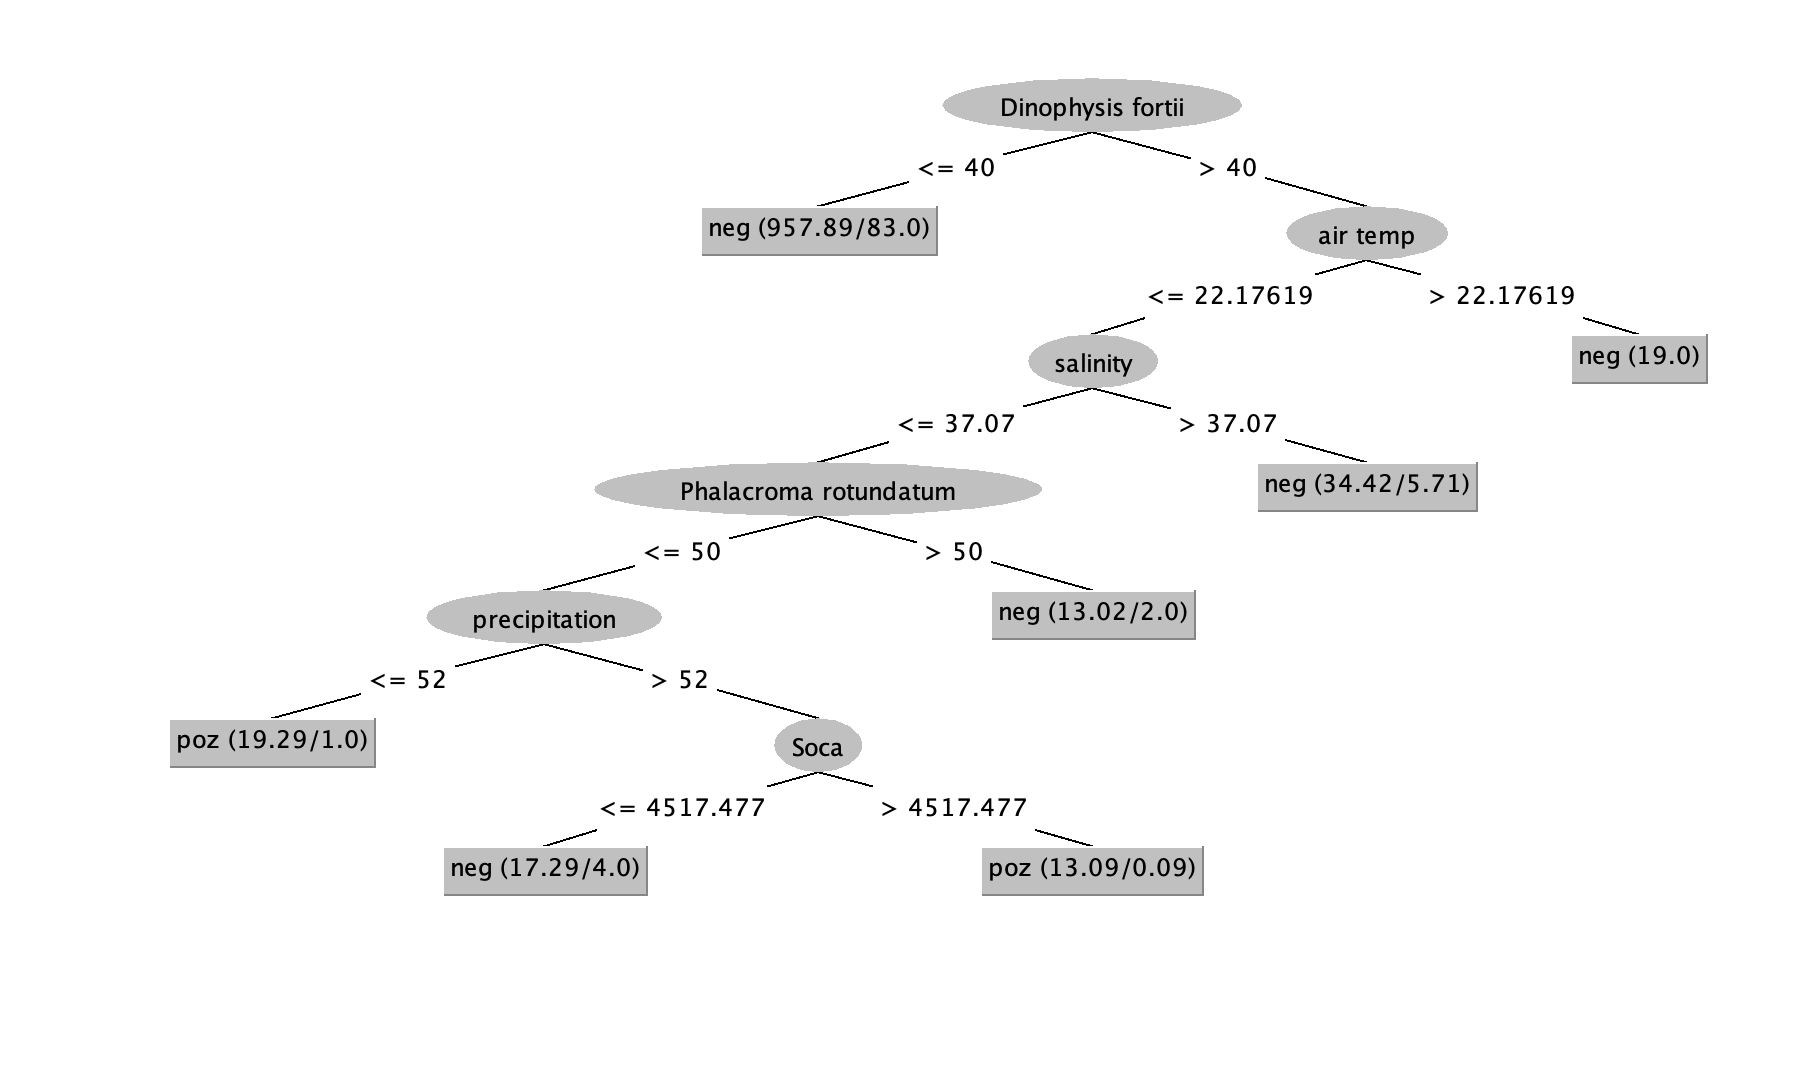

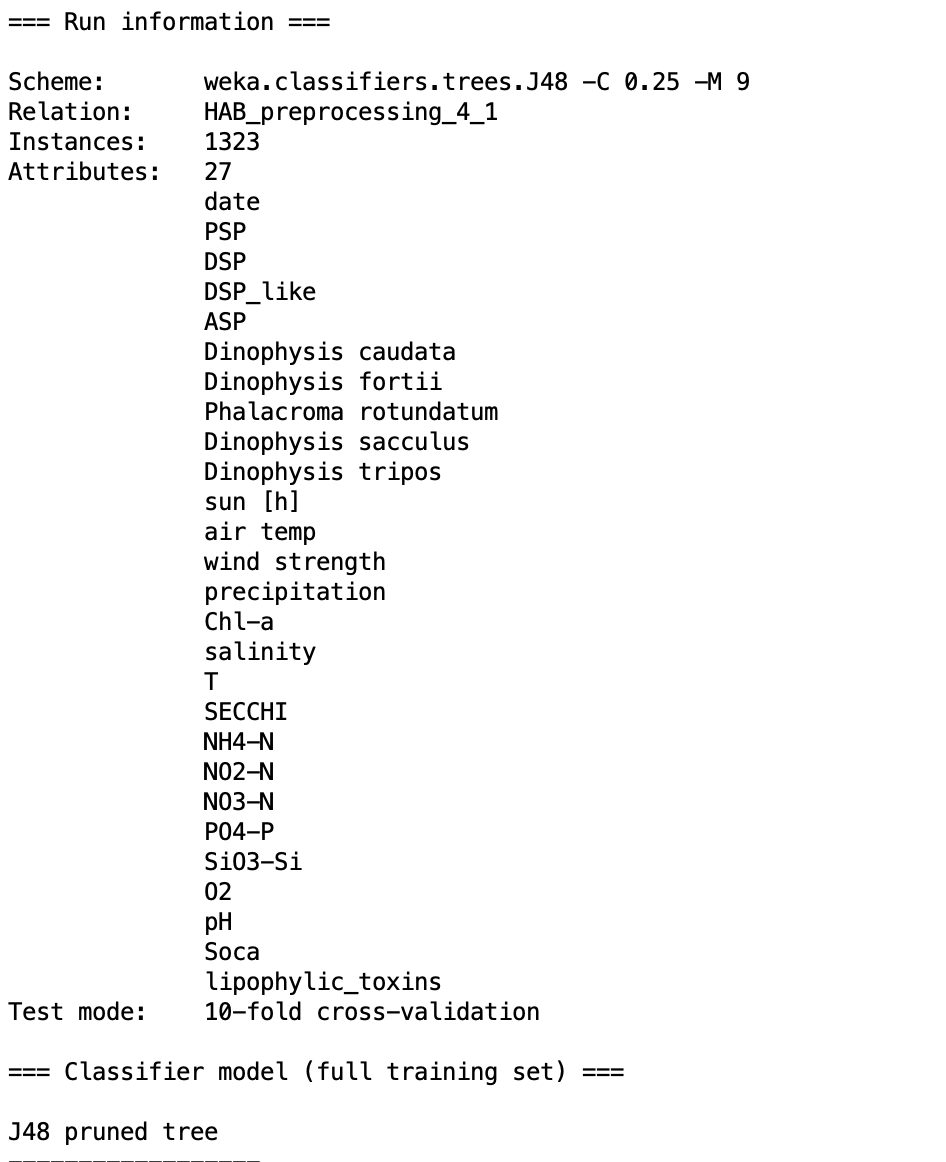

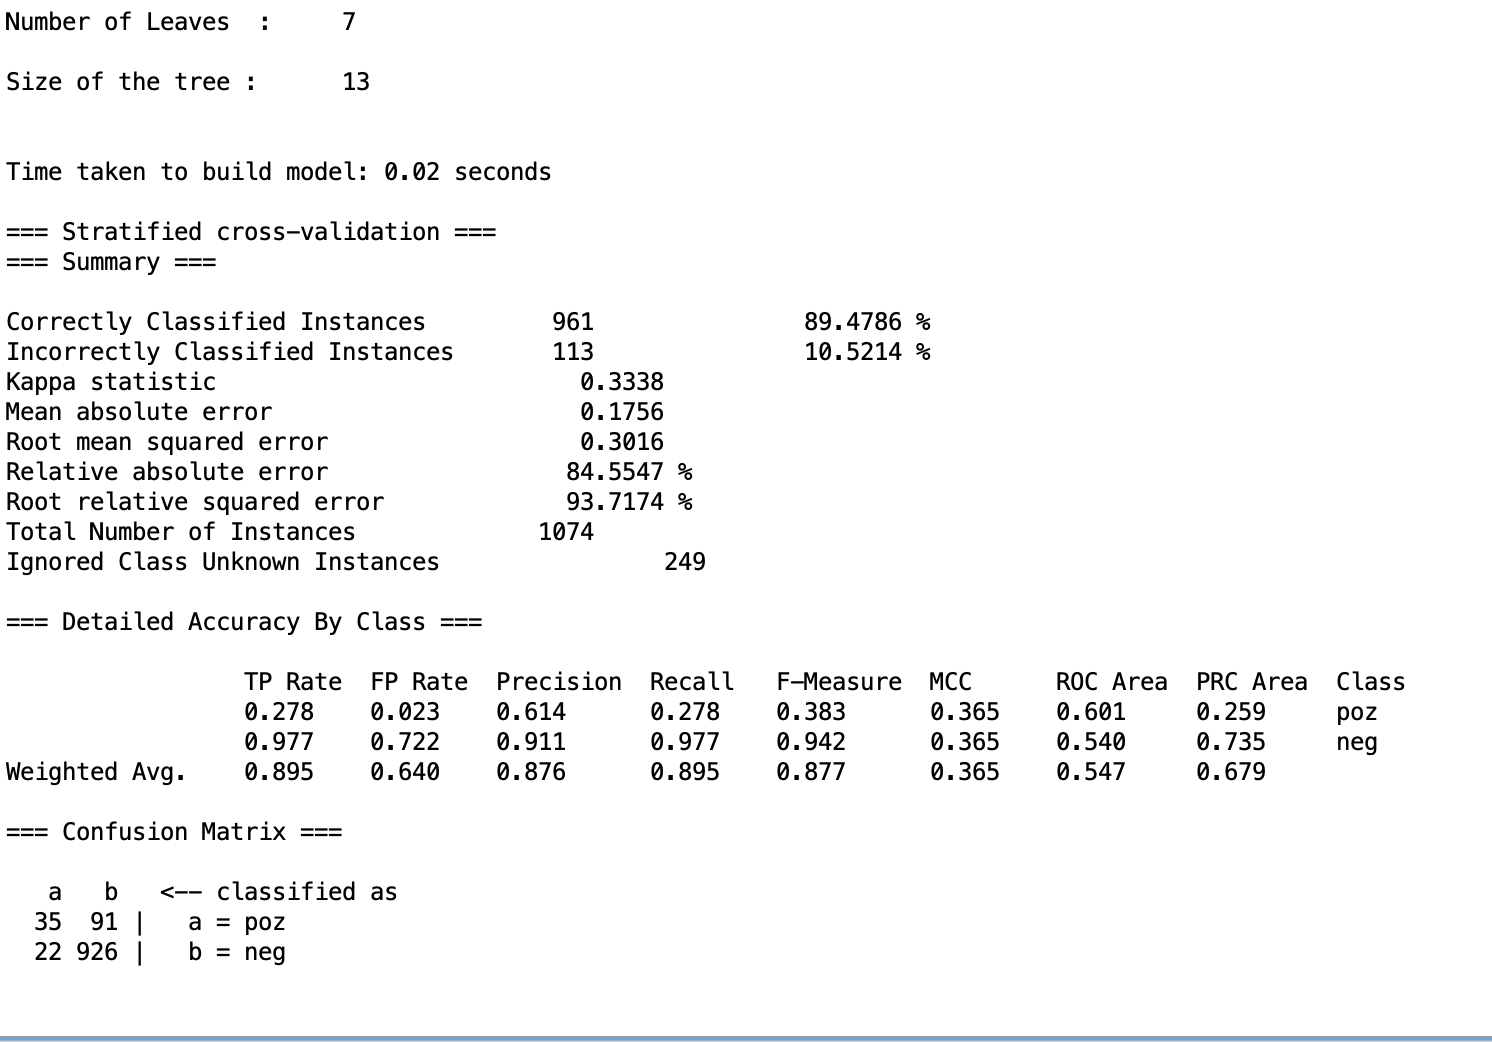

### Ensemble Classifier: Random Forest

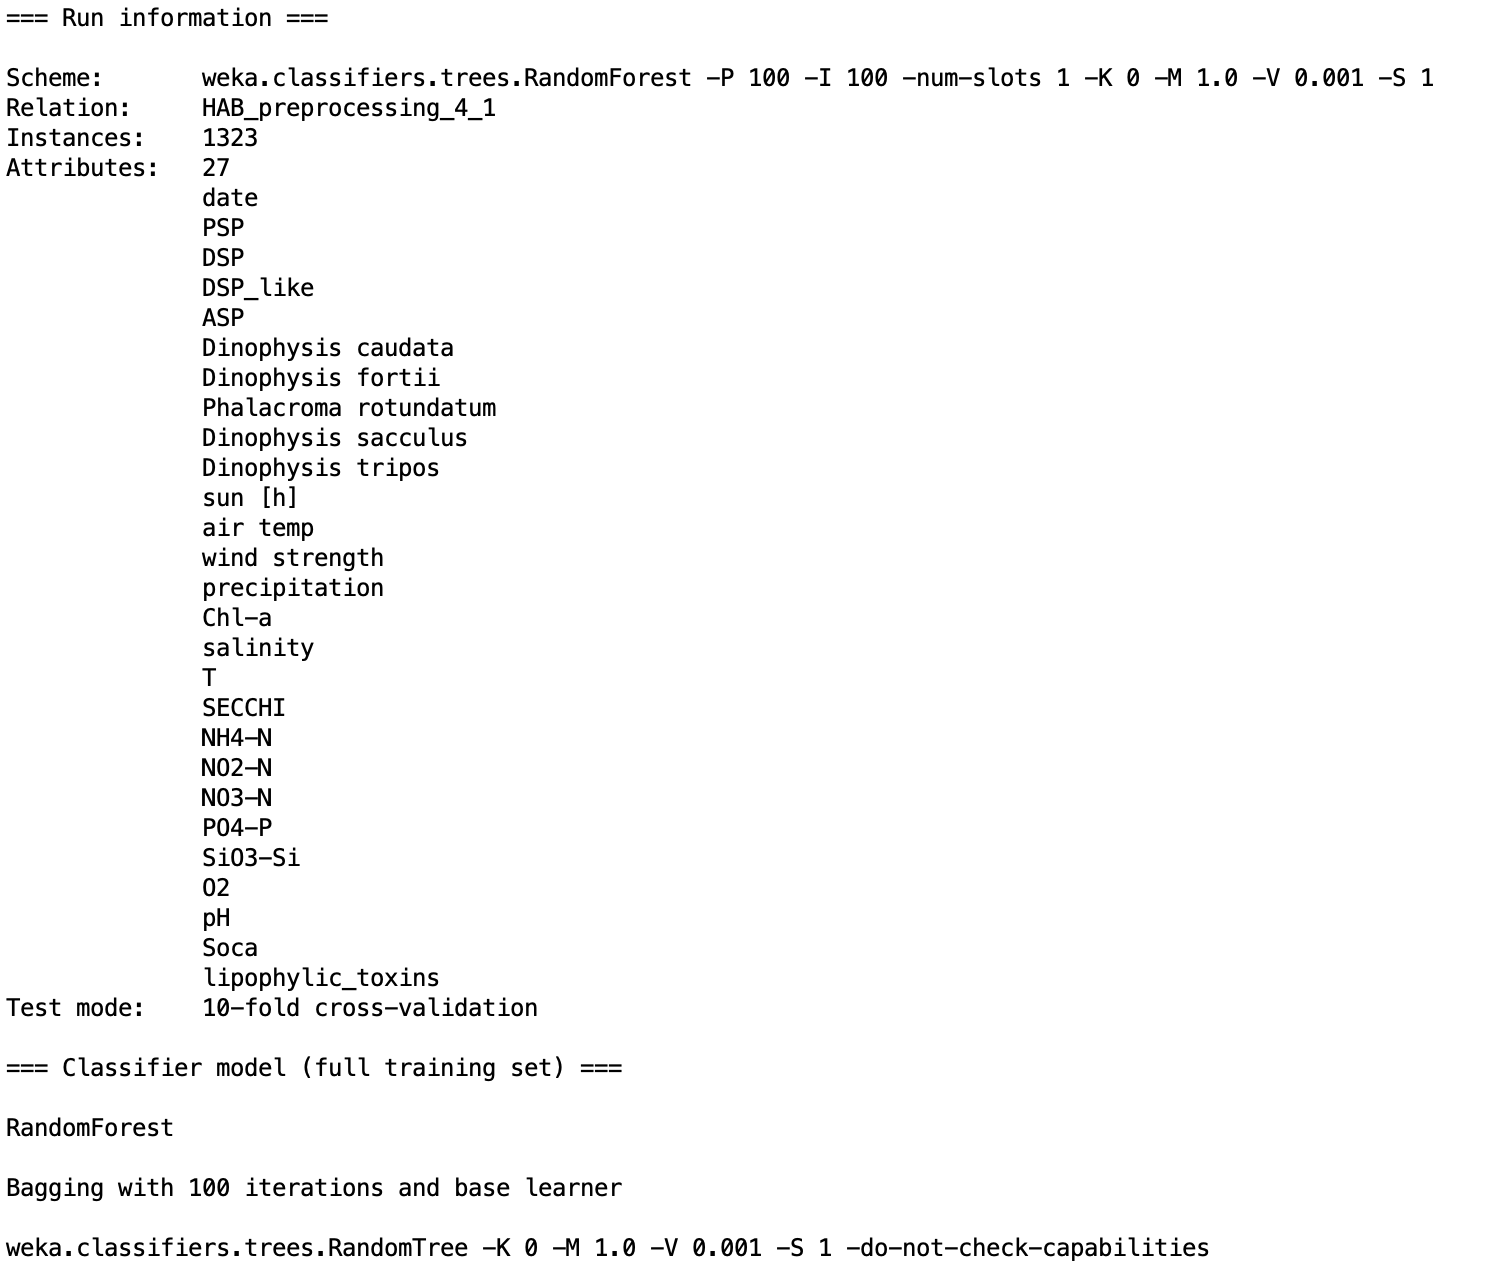

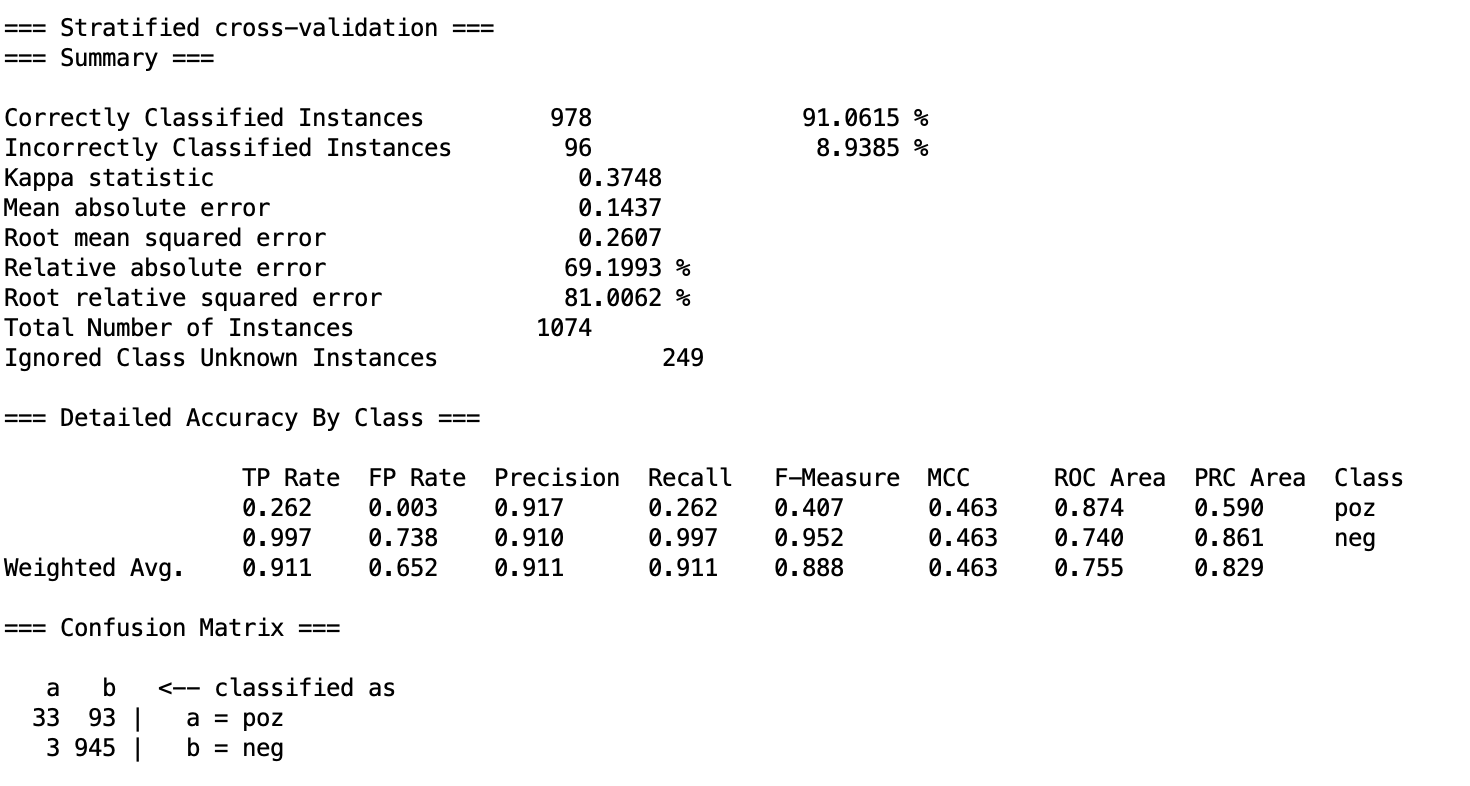

## C5.0

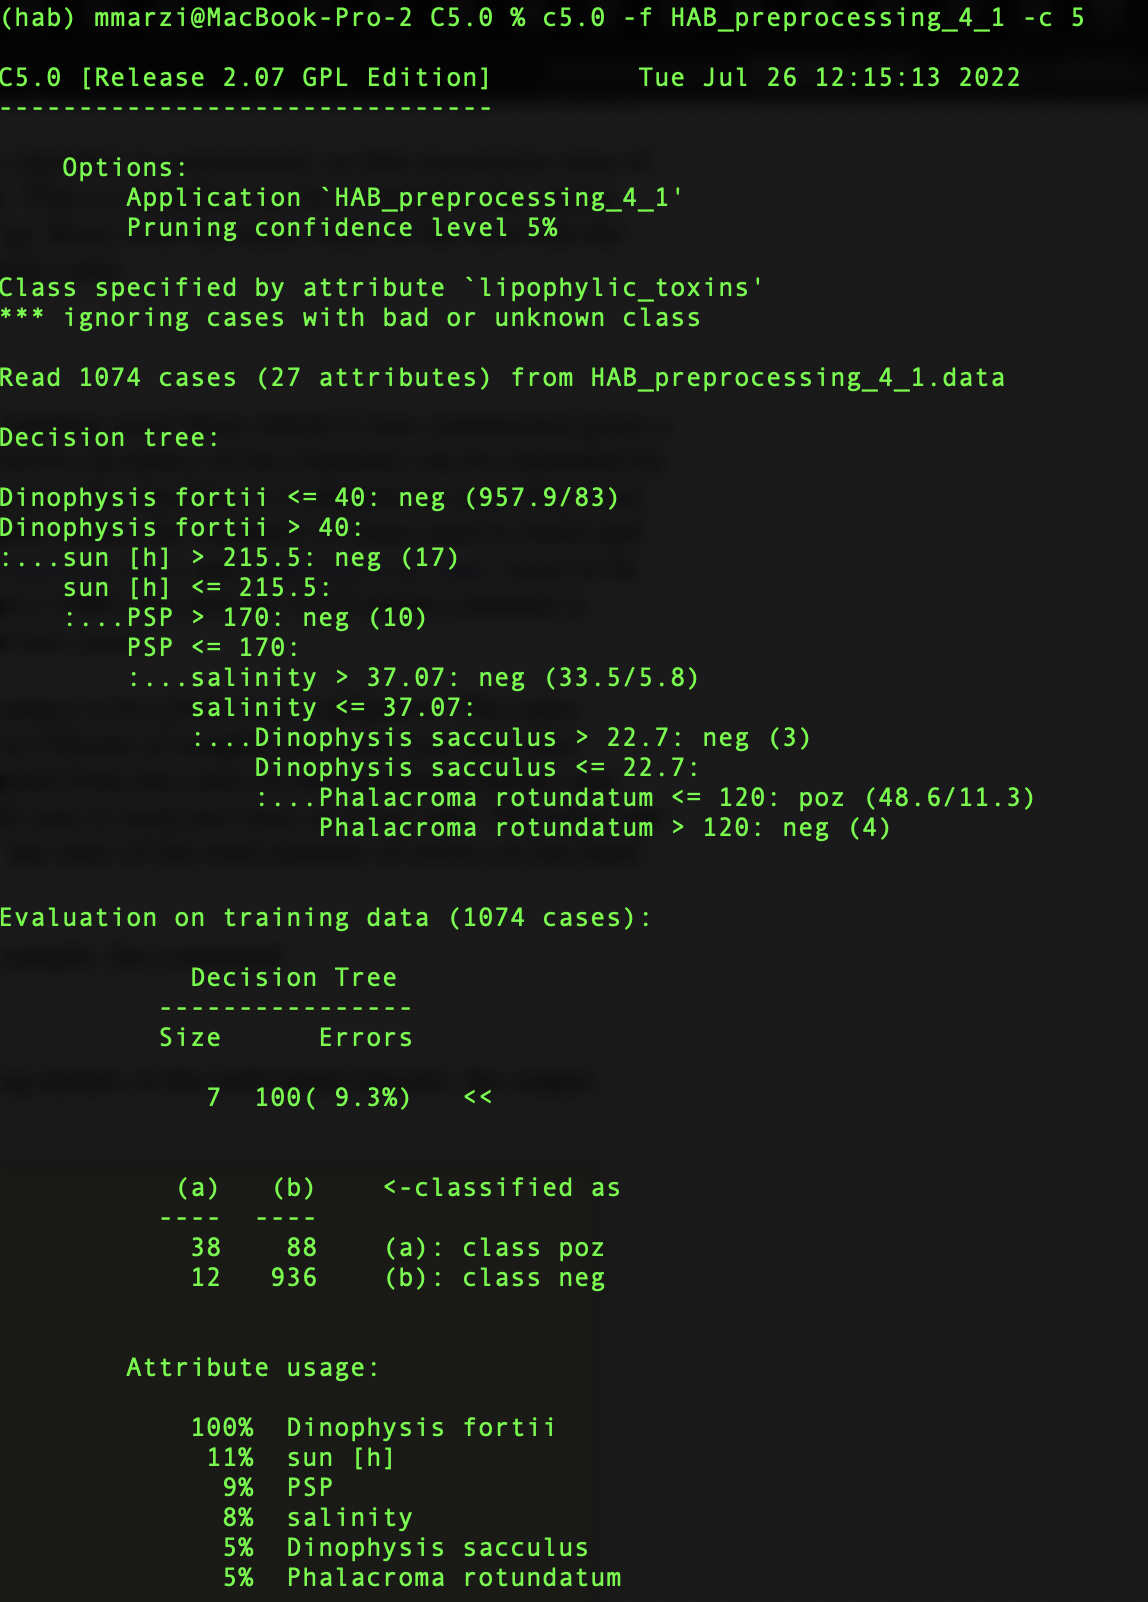

# Scikit-learn Analysis

In [118]:
df_cons_SL = df_cons.copy()
df_cons_SL.drop(columns=["sampling station"], inplace =True)
# df_cons_SL
# df_cons_SL.describe()

In [119]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 30)

df_cons_SL.isnull().sum()

DSP                        1
DSP_like                  60
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    661
salinity                 191
T                        244
SECCHI                   696
DIN                      542
PO4-P                    534
temp_dif                 346
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

In [105]:
# Removing features
df_cons_SL.drop(columns=["DSP_like", "SECCHI", "Chl-a","DIN", "PO4-P", "temp_dif", "T"], inplace=True)#, "Chl-a","DIN", "PO4-P", 

# df_cons_SL.to_pickle("objects/df_cons_SL-???")

# df_cons_SL.isnull().sum()

In [106]:
# # remove instances with missing values in target class
# df_cons_SL = df_cons_SL.dropna(subset=['lipophylic_toxins'], how="any").copy()

# Class distribution
df_cons_SL["lipophylic_toxins"].value_counts(dropna=False)

neg    996
NaN    320
poz    136
Name: lipophylic_toxins, dtype: int64

In [107]:
# [Continuation...] Preprocessing for scikit_learn

# labeled and unlabeled part
df_cons_SL_l = df_cons_SL[df_cons_SL['lipophylic_toxins'].notnull()]
df_cons_SL_u = df_cons_SL[df_cons_SL['lipophylic_toxins'].isnull()]

# Remove missing values
df_cons_SL_l = df_cons_SL.dropna(how="any").copy()

X = df_cons_SL_l.copy().drop("lipophylic_toxins", axis=1)
y = df_cons_SL_l["lipophylic_toxins"]

# sklearn lable encoding
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(f"class encoding: ['neg','poz'] -> {le.transform(['neg','poz'])}")

class encoding: ['neg','poz'] -> [0 1]


In [108]:
# Check remaining poz instances
df_cons_SL_l["lipophylic_toxins"].value_counts(dropna=False)

neg    995
poz    136
Name: lipophylic_toxins, dtype: int64

## Model Training and Evaluation

### Decision Tree Model (sklearn)

In [116]:
pipeline = IMBLpipeline([
   ('smt', SMOTE()), 
   ('under', RandomUnderSampler()), 
    ('clf', DecisionTreeClassifier())
])

parameters = {
              'clf__max_depth': [2,3,4],
                'clf__criterion': ['gini', 'entropy'],
              'clf__class_weight': ['balanced', 'balanced_subsample', None],
               'smt__sampling_strategy': [0.2, 0.4, 0.5],
               'under__sampling_strategy': [0.7, 0.8],
                'smt__k_neighbors': [3, 5]
             }
nfolds = 3
scores = ['recall', 'precision', 'f1', 'roc_auc']
gscv = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit="recall",
                    n_jobs=-1)
resultsGSCV = gscv.fit(X, y)
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_recall']).transpose())
pd.set_option("display.max_rows", None)

Fitting 3 folds for each of 216 candidates, totalling 648 fits



216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 969, in fit
    super().fit(
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/

30   \
mean_fit_time                                                            0.018726   
std_fit_time                                                             0.000614   
mean_score_time                                                          0.011064   
std_score_time                                                           0.000844   
param_clf__class_weight                                                  balanced   
param_clf__criterion                                                         gini   
param_clf__max_depth                                                            4   
param_smt__k_neighbors                                                          5   
param_smt__sampling_strategy                                                  0.2   
param_under__sampling_strategy                                                0.7   
params                          {'clf__class_weight': 'balanced', 'clf__criter...   
split0_test_recall                                                        0.76087   
split1_test_recall                                                       0.666667   
split2_test_recall                                                            0.6   
mean_test_recall                                                         0.675845   
std_test_recall                                                          0.065995   
rank_test_recall                                                                1   
split0_test_precision                                                    0.214724   
split1_test_precision                                                    0.201342   
split2_test_precision                                                    0.247706   
mean_test_precision                                                      0.221258   
std_test_precision                                                       0.019484   
rank_test_precision                                                            92   
split0_test_f1                                                           0.334928   
split1_test_f1                                                           0.309278   
split2_test_f1                                                           0.350649   
mean_test_f1                                                             0.331619   
std_test_f1                                                              0.017051   
rank_test_f1                                                                   32   
split0_test_roc_auc                                                      0.752693   
split1_test_roc_auc                                                      0.713052   
split2_test_roc_auc                                                      0.687517   
mean_test_roc_auc                                                        0.717754   
std_test_roc_auc                                                         0.026815   
rank_test_roc_auc                                                              12   

                                                                              23   \
mean_fit_time                                                            0.021927   
std_fit_time                                                             0.000126   
mean_score_time                                                           0.01134   
std_score_time                                                           0.001292   
param_clf__class_weight                                                  balanced   
param_clf__criterion                                                         gini   
param_clf__max_depth                                                            3   
param_smt__k_neighbors                                                          5   
param_smt__sampling_strategy                                                  0.5   
param_under__sampling_strategy                                                0.8   
params                          {'clf__class_weight': 'balanced', 'clf__criter... 

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


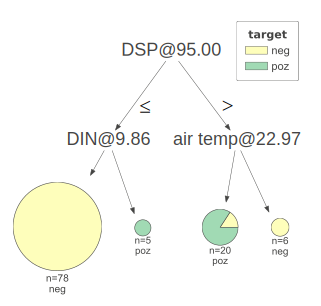

In [24]:
clf = gscv.best_estimator_.steps[2][1]
viz = dtreeviz(clf, X, y,
                target_name="target",
                feature_names=X.columns,
                class_names=["neg", "poz"],
             fancy=False,
               scale=1.5
              )

viz

### Random Forest Model

#### Model evaluation (Random Forest)

In [11]:
# Random forest with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
   ('smt', SMOTE()), 
   ('under', RandomUnderSampler()), 
    ('clf', RandomForestClassifier())
])

parameters = {
              'clf__n_estimators': [300,500],
              'clf__criterion': ['gini', 'entropy'],
              'clf__class_weight': ['balanced', 'balanced_subsample', None],
               'smt__sampling_strategy': [ 0.2, 0.4, 0.5],
               'under__sampling_strategy': [0.7, 0.8],
                'smt__k_neighbors': [3, 5]
             }
nfolds = 3
scores = ['recall', 'precision', 'f1', 'roc_auc']
gscv = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit="recall",
                    n_jobs=-1)
resultsGSCV = gscv.fit(X, y)
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_recall']).transpose())
pd.set_option("display.max_rows", None)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


91   \
mean_fit_time                                                            1.555082   
std_fit_time                                                             0.005241   
mean_score_time                                                          0.218719   
std_score_time                                                           0.005342   
param_clf__class_weight                                        balanced_subsample   
param_clf__criterion                                                      entropy   
param_clf__n_estimators                                                       500   
param_smt__k_neighbors                                                          5   
param_smt__sampling_strategy                                                  0.2   
param_under__sampling_strategy                                                0.8   
params                          {'clf__class_weight': 'balanced_subsample', 'c...   
split0_test_recall                                                            1.0   
split1_test_recall                                                            1.0   
split2_test_recall                                                            0.6   
mean_test_recall                                                         0.866667   
std_test_recall                                                          0.188562   
rank_test_recall                                                                1   
split0_test_precision                                                    0.357143   
split1_test_precision                                                    0.454545   
split2_test_precision                                                         0.5   
mean_test_precision                                                      0.437229   
std_test_precision                                                       0.059593   
rank_test_precision                                                           144   
split0_test_f1                                                           0.526316   
split1_test_f1                                                              0.625   
split2_test_f1                                                           0.545455   
mean_test_f1                                                              0.56559   
std_test_f1                                                               0.04273   
rank_test_f1                                                                   89   
split0_test_roc_auc                                                      0.921875   
split1_test_roc_auc                                                      0.954839   
split2_test_roc_auc                                                      0.870968   
mean_test_roc_auc                                                        0.915894   
std_test_roc_auc                                                           0.0345   
rank_test_roc_auc                                                              13   

                                                                              123  \
mean_fit_time                                                            0.851163   
std_fit_time                                                             0.003715   
mean_score_time                                                          0.164675   
std_score_time                                                           0.017864   
param_clf__class_weight                                                      None   
param_clf__criterion                                                      entropy   
param_clf__n_estimators                                                       300   
param_smt__k_neighbors                                                          3   
param_smt__sampling_strategy                                                  0.4   
param_under__sampling_strategy                                                0.8   
params                          {'clf__class_weight': None, 'clf__criterion': ... 

#### Feature importance (Random Forest)

Text(0.5, 1.0, 'Permutation Importance Random Forest')

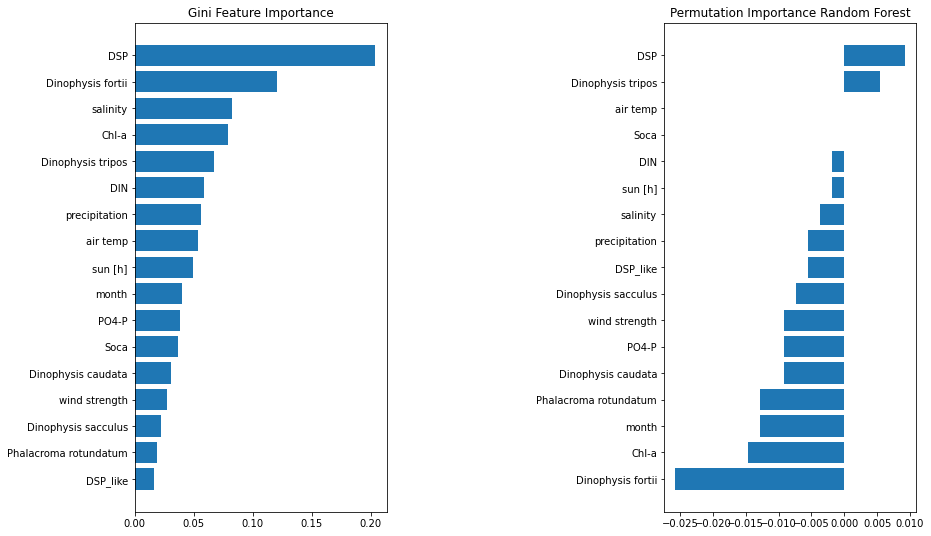

In [12]:
# Feature importance of model (best RandomForest from gridsearch) with three methods!

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,9))
plt.subplots_adjust(wspace=1.1)

rf = gscv.best_estimator_.steps[2][1]

# Get feature importance with Gini importance (mean decreased impurity)
# print(rf.feature_importances_)
gini_sorted_idx = rf.feature_importances_.argsort()
x1 = X.columns[gini_sorted_idx]
y1 = rf.feature_importances_[gini_sorted_idx]
ax1.barh(x1, y1)
ax1.set_title("Gini Feature Importance")

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(rf, X, y)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance Random Forest")

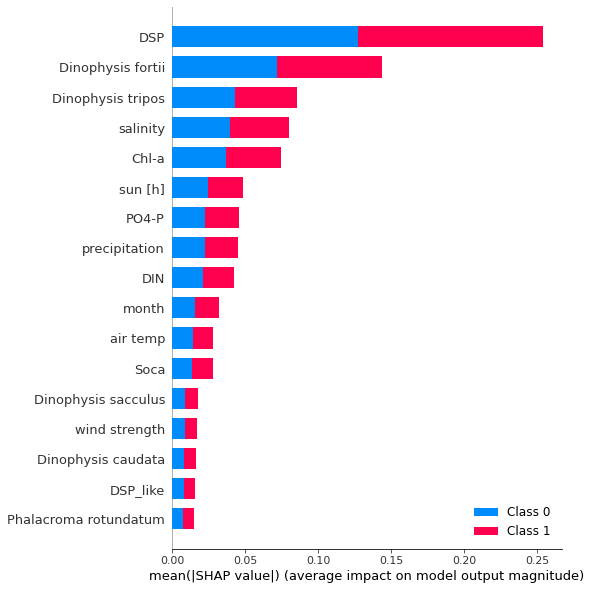

In [13]:
# Get feature importance with SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
RF_shap = shap.summary_plot(shap_values, X, plot_type="bar")

### Neural Network Model

#### Model Evaluation (MLP)

In [14]:
# Preprocessing for NN in scikit_learn

# Model evaluation with the pipeline of SMOTE oversampling and undersampling on the training dataset only (within each cross-validation fold)!

# one-hot encoding of month feature
Xohe = pd.get_dummies(X, columns=["month"])

# scalling numeric values for NN
scaled_array = StandardScaler().fit_transform(Xohe)
Xsc = pd.DataFrame(scaled_array, columns=Xohe.columns)

In [15]:
# pd.set_option("display.max_rows", None)

In [16]:
# MLP with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
    ('over', SMOTE()),
    ('under', RandomUnderSampler()),
    ('clf', MLPClassifier(solver='lbfgs', max_iter=5000))
])

parameters = {'over__k_neighbors': range(1,7),
              'over__sampling_strategy': [0.2, 0.4, 0.5],
              'under__sampling_strategy': [0.6, 0.7, 0.8],
              'clf__hidden_layer_sizes': [(2, ), (2, 2), (3,), (3,3)],
             }
nfolds = 3
scores = ['recall', "precision", 'f1', 'roc_auc']
gscv = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    n_jobs= -1, 
                    return_train_score=False, 
                    verbose=1, 
                    refit= "recall")
resultsGSCV = gscv.fit(Xsc, y)
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_recall']).transpose())

Fitting 3 folds for each of 216 candidates, totalling 648 fits


18   \
mean_fit_time                                                             0.04873   
std_fit_time                                                             0.005084   
mean_score_time                                                          0.015168   
std_score_time                                                           0.001254   
param_clf__hidden_layer_sizes                                                (2,)   
param_over__k_neighbors                                                         3   
param_over__sampling_strategy                                                 0.2   
param_under__sampling_strategy                                                0.6   
params                          {'clf__hidden_layer_sizes': (2,), 'over__k_nei...   
split0_test_recall                                                            1.0   
split1_test_recall                                                            1.0   
split2_test_recall                                                            0.8   
mean_test_recall                                                         0.933333   
std_test_recall                                                          0.094281   
rank_test_recall                                                                1   
split0_test_precision                                                    0.333333   
split1_test_precision                                                         0.5   
split2_test_precision                                                    0.333333   
mean_test_precision                                                      0.388889   
std_test_precision                                                       0.078567   
rank_test_precision                                                            16   
split0_test_f1                                                                0.5   
split1_test_f1                                                           0.666667   
split2_test_f1                                                           0.470588   
mean_test_f1                                                             0.545752   
std_test_f1                                                              0.086339   
rank_test_f1                                                                    2   
split0_test_roc_auc                                                          0.85   
split1_test_roc_auc                                                      0.883871   
split2_test_roc_auc                                                      0.819355   
mean_test_roc_auc                                                        0.851075   
std_test_roc_auc                                                          0.02635   
rank_test_roc_auc                                                               1   

                                                                              153  \
mean_fit_time                                                            0.035779   
std_fit_time                                                             0.002039   
mean_score_time                                                          0.011822   
std_score_time                                                           0.000951   
param_clf__hidden_layer_sizes                                                (3,)   
param_over__k_neighbors                                                         6   
param_over__sampling_strategy                                                 0.2   
param_under__sampling_strategy                                                0.6   
params                          {'clf__hidden_layer_sizes': (3,), 'over__k_nei...   
split0_test_recall                                                            1.0   
split1_test_recall                                                            0.6   
split2_test_recall                                                            0.8   
mean_test_recall                                                              0.8 

#### Feature Importance (MLP)

Text(0.5, 1.0, 'Permutation Importance MLP')

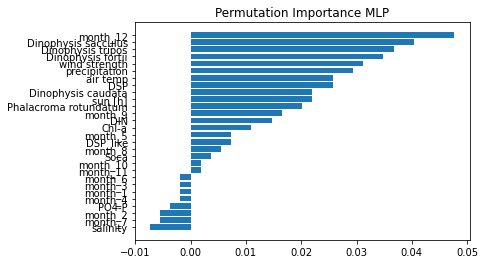

In [17]:
# Feature importance of model (MLP)  (no cross-validation!)

fig, (ax2) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=3)

MLP = gscv.best_estimator_.steps[2][1]

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(MLP, Xsc, y)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = Xsc.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance MLP")

In [ ]:
# explain the model's predictions using SHAP
import shap
# explainer = shap.KernelExplainer(clf.predict_proba, X_train)
explainer = shap.KernelExplainer(MLP.predict_proba, shap.sample(Xsc, 10))
shap_values = explainer.shap_values(Xsc)

In [19]:
# # visualize the first prediction's explanation (Shapley value is the average contribution of features which are predicting in different situation).
# shap.summary_plot(shap_values, X_test)

### Conclusion

In [20]:
# Summary table of prediction results
RF_recall = round(RF_recall_best_k[1], 2)
RF_auc = round(RF_auc_best_k[1], 2)
MLP_recall = round(MLP_recall_best_k[1], 2)
MLP_auc = round(MLP_auc_best_k[1], 2)

summary = pd.DataFrame(
    [
        (
            "RF",
            RF_recall_score,
            RF_auc_score,
        ),
        (
            "MLP",
            MLP_recall_score,
            MLP_auc_score,
        ),
        (
            "RF (smote)",
            RF_recall,
            RF_auc,
        ),
        (
            "MLP (smote)",
            MLP_recall,
            MLP_auc,
        ),
        (
            "Decision tree (J48)*",
            0.56,
            0.18,
        ),
    ],
    columns=("Model", "Recall", "ROC AUC"),
).set_index("Model")

print("Table summarising the prediction results of the used classifiers, both with and without SMOTE resampling:\n")
summary.round(2)

NameError: name 'RF_recall_best_k' is not defined

As can be seen resampling with SMOTE helped to improve the results substantially, especially when calculating recall. The highest recall and ROC AUC was achieved with Random Forest with the re-sampled data. Both recall and ROC AUC suggest Random Forest as beeing the better classifier for this particular problem. Recall is a crucial metric as it gives indication of what fraction of true positive instances have been predicted. Since the models predict toxins in seashells (food) it is crucial that as few positives as possible are missed.

Due to the use of SMOTE resampling (upsampling and downsampling) in combinaiton with cross-validation it was curcial to do the resampling within each fold to avoid data lekeage and validate on original (unsampled) data. In addition, I have optimised the model with regard to the k-values of SMOTE, all of which brought along some complexity. So for the parameter tuning of Random Forest and MLP various parameter settings have been tried  and the model with best performing settings has been chosen.

The decision tree J48 algorithm was run within Weka on a slightly different dataset (missing values were not removed to use as many instances as possible, cross validation was 10-fold as opposed to 3-fold due to a higher dataset etc.) thus this results are not directly comparable but were provided as a reference to give an indication of the performance of this algorithm. 

As can be seen in the feature importance bar plots above, similar features were on the top despite using two different classification algorithms and two different feature ranking methods. If we consider just the three highest-ranking features of each of the feature ranking methods for both algortihms (RF and MLP) the features that overlap are DSP, DSP_like, ASP, Dinophysis fortii and Dinophysis caudata. These can be shown to the domain experts for validation and interpretation.